# Pre-process

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [13]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
#Read corpus
corpus = open('./data/corpus', 'r').read()
# Tokenização
words = word_tokenize(corpus)

# Obtendo a lista de stopwords para o inglês
stop_words = set(stopwords.words('english'))

# Removendo stopwords
filtered_words = [word for word in words if word.lower() not in stop_words]

#
size_of_sentence = 20
sentences = [filtered_words[i:i+size_of_sentence] for i in range(0, len(filtered_words), size_of_sentence)]



#### O pré-processamento foi implementado com operações simples devido ao corpus já possuir todos os seus caracteres em minúscula e sem pontuações. O fato de não haver pontuação e nem quebras de linha motivou o uso de um tamanho máximo para cada sentença. O corpus foi dividido em sentenças de 20 palavras (número escolhido com base no tamanho médio de sentenças em um texto simples). Essa etapa é importante pois pode influenciar no resultado do modelo, embora não tenha entrado na experimentação. A escolha do hiperparâmetro window_size deve considerar a escolha do tamanho da sentença do pré-processamento.

In [12]:
#Read analogy
f = open("data/questions-words.txt", "r")

# Experimentações

In [13]:
import random
import numpy as np
from gensim.models import Word2Vec

random.seed(42)

rows = f.read().split('\n')
rows = rows[1:]



In [17]:
hyperparam_grid = {
    'epochs': [10, 25, 50],
    'vector_size': [50, 100],
    'window': [5, 10],
    'min_count': [1, 1000, 3000, 5000],
    'sg': [0, 1]
}

In [18]:
import random
from numpy.linalg import norm

random.seed(42)


def inference(model):
    hits = 0
    wrong = 0
    not_found = 0
    distances = []

    for i, row in enumerate(rows):
        word_list = row.split(' ')
        context_words = [word.lower() for word in word_list]

        if len(context_words) == 4:
            p1, c1, p2, c2 = context_words
            
            random_word = random.choice([p1, c1, p2, c2])

            try:

                if random_word == p1:
                    result_vector = model.wv[c2] - model.wv[c1] + model.wv[p2]
                elif random_word == c1:
                    result_vector = model.wv[p1] - model.wv[p2] + model.wv[c2]
                elif random_word == p2:
                    result_vector = model.wv[c1] - model.wv[c2] + model.wv[p1]
                elif random_word == c2:
                    result_vector = model.wv[p1] - model.wv[p2] + model.wv[c1]

                predicted_words = model.wv.most_similar(positive=[result_vector], topn=10, restrict_vocab=None)
                predicted_word = next((word for word, score in predicted_words if word not in word_list), None)

                if predicted_word:
                    distance = norm(model.wv[predicted_word] - model.wv[random_word])
                    distances.append(distance)

                    if predicted_word == random_word:
                        hits += 1
                    else:
                        wrong += 1
            except KeyError:
                not_found += 1

    avg_distance = sum(distances) / len(distances) if distances else 0
    return hits, wrong, not_found, avg_distance



In [19]:
def train_and_evaluate(params, sentences):
    model = Word2Vec(sentences, vector_size=params['vector_size'], window=params['window'], 
                     min_count=params['min_count'], workers=4, sg=params['sg'])
    model.train(sentences, total_examples=len(sentences), epochs=params['epochs'])
    
    hits, wrong, not_found, avg_distance = inference(model)
    if (hits + wrong) == 0:
        accuracy = 0
    else:
        accuracy = hits / (hits + wrong)  # This computes accuracy. You can change it according to your requirements.

    score = model.wv.evaluate_word_analogies('data/questions-words.txt')[0]
    
    print(f"Score: {score}, Accuracy: {accuracy}, Hits: {hits}, Wrong: {wrong}, Not found: {not_found}, Avg. distance: {avg_distance}")
    return score, accuracy, hits, wrong, not_found, avg_distance


In [20]:
results = {}
for epochs in hyperparam_grid['epochs']:
    for vector_size in hyperparam_grid['vector_size']:
        for window in hyperparam_grid['window']:
            for min_count in hyperparam_grid['min_count']:
                for sg in hyperparam_grid['sg']:
                    params = {
                        'epochs': epochs,
                        'vector_size': vector_size,
                        'window': window,
                        'min_count': min_count,
                        'sg': sg,
                        'model_type': 'CBOW' if sg == 0 else 'Skip-gram'
                    }
                    print(f"Training model with parameters: {params}")
                    score, accuracy, hits, wrong, not_found, avg_distance = train_and_evaluate(params, sentences)
                    results[str(params)] = {
                        'score': score,
                        'accuracy': accuracy,
                        'hits': hits,
                        'wrong': wrong,
                        'not_found': not_found,
                        'avg_distance': avg_distance 
                    }


Training model with parameters: {'epochs': 10, 'vector_size': 50, 'window': 5, 'min_count': 1, 'sg': 0, 'model_type': 'CBOW'}
Score: 0.23153439153439154, Accuracy: 0.011904761904761904, Hits: 225, Wrong: 18675, Not found: 644, Avg. distance: 11.073382075848404
Training model with parameters: {'epochs': 10, 'vector_size': 50, 'window': 5, 'min_count': 1, 'sg': 1, 'model_type': 'Skip-gram'}
Score: 0.2329100529100529, Accuracy: 0.016984126984126983, Hits: 321, Wrong: 18579, Not found: 644, Avg. distance: 3.3128522989516536
Training model with parameters: {'epochs': 10, 'vector_size': 50, 'window': 5, 'min_count': 1000, 'sg': 0, 'model_type': 'CBOW'}
Score: 0.6409185803757829, Accuracy: 0.081419624217119, Hits: 39, Wrong: 440, Not found: 19065, Avg. distance: 10.784975733786883
Training model with parameters: {'epochs': 10, 'vector_size': 50, 'window': 5, 'min_count': 1000, 'sg': 1, 'model_type': 'Skip-gram'}
Score: 0.6346555323590815, Accuracy: 0.09603340292275574, Hits: 46, Wrong: 433, N

In [21]:
import pandas as pd
import ast

def results_to_dataframe(results):
    # Transformando as chaves (strings) de volta para dicionários
    param_dicts = [ast.literal_eval(key) for key in results.keys()]
    
    # Extraindo os valores correspondentes
    values = list(results.values())
    
    # Juntando os parâmetros e os valores em uma única lista de dicionários
    merged_dicts = []
    for p, v in zip(param_dicts, values):
        merged_dict = {**p, **v}
        merged_dicts.append(merged_dict)
    
    # Convertendo a lista de dicionários para um DataFrame
    df = pd.DataFrame(merged_dicts)
    
    return df

# Uso da função
df_results = results_to_dataframe(results)

# Mostrando o DataFrame (opcional)
print(df_results)


df_results.to_csv('results.csv', index=False)

    epochs  vector_size  window  min_count  sg model_type     score  accuracy  \
0       10           50       5          1   0       CBOW  0.231534  0.011905   
1       10           50       5          1   1  Skip-gram  0.232910  0.016984   
2       10           50       5       1000   0       CBOW  0.640919  0.081420   
3       10           50       5       1000   1  Skip-gram  0.634656  0.096033   
4       10           50       5       3000   0       CBOW  0.833333  0.083333   
..     ...          ...     ...        ...  ..        ...       ...       ...   
91      50          100      10       1000   1  Skip-gram  0.716075  0.073069   
92      50          100      10       3000   0       CBOW  0.833333  0.166667   
93      50          100      10       3000   1  Skip-gram  0.833333  0.166667   
94      50          100      10       5000   0       CBOW  0.000000  0.000000   
95      50          100      10       5000   1  Skip-gram  0.000000  0.000000   

    hits  wrong  not_found 

# Analisys

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_results = pd.read_csv('results.csv')

In [5]:
top_5_scores = df_results.nlargest(5, 'score')
top_5_scores[['score', 'model_type', 'epochs', 'vector_size', 'window', 'min_count', 'sg']]

,score,model_type,epochs,vector_size,window,min_count,sg
36,0.916667,CBOW,25,50,5,3000,0
44,0.916667,CBOW,25,50,10,3000,0
61,0.916667,Skip-gram,25,100,10,3000,1
68,0.916667,CBOW,50,50,5,3000,0
4,0.833333,CBOW,10,50,5,3000,0


##### Podemos observar que o modelo CBOW dominou a maior parte dos top 5 scores. O top 5 score também evidencia um padrão nos hiperparâmetros: 
    - epochs: 25
    - vector_size: 50
    - min_count: 3000


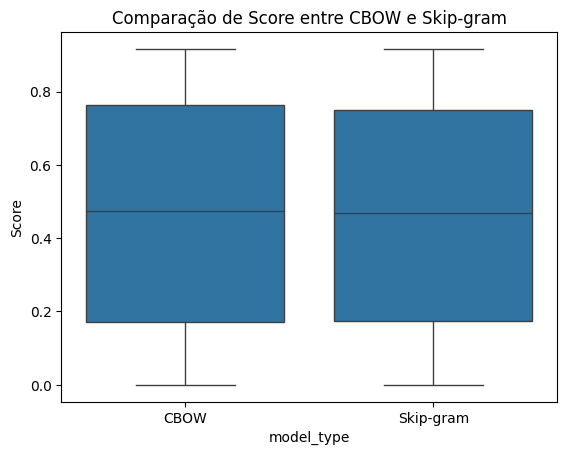

In [6]:
sns.boxplot(x='model_type', y='score', data=df_results)
plt.title('Comparação de Score entre CBOW e Skip-gram')
plt.ylabel('Score')
plt.show()


##### Através do boxplot podemos observar uma leve vantagem do modelo CBOW em termos de score.

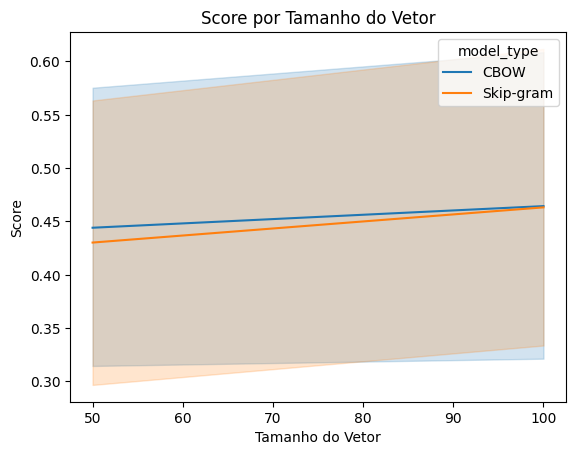

In [7]:
sns.lineplot(x='vector_size', y='score', hue='model_type', data=df_results)
plt.title('Score por Tamanho do Vetor')
plt.ylabel('Score')
plt.xlabel('Tamanho do Vetor')
plt.show()


#### O tamanho do vetor gerado define o quão compacta será a representação de uma determinada palavra. Vetores maiores tendem a capturar mais características, mas isso pode levar a overfitting. Já vetores menores podem causar underfitting por serem muito simplistas. Neste caso, é possível observar que o tamanho do vetor não afetou consideravelmente o resultado final dos modelos.

Text(0.5, 0, 'Window Size')

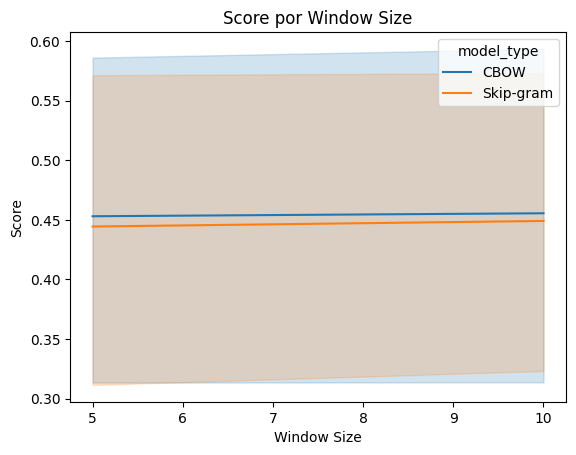

In [8]:
#Score por window size
sns.lineplot(x='window', y='score', hue='model_type', data=df_results)
plt.title('Score por Window Size')
plt.ylabel('Score')
plt.xlabel('Window Size')


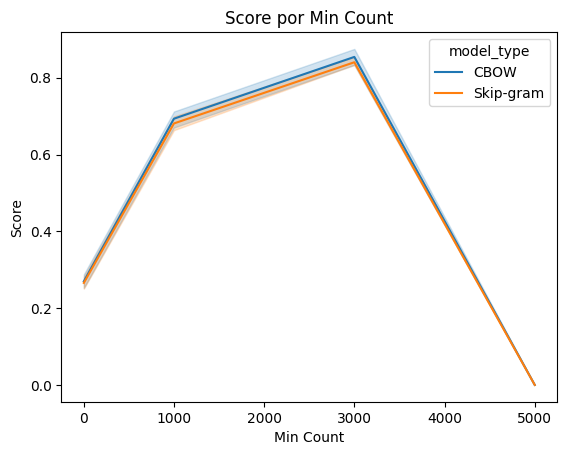

In [9]:
#score por min_count
sns.lineplot(x='min_count', y='score', hue='model_type', data=df_results)
plt.title('Score por Min Count')
plt.ylabel('Score')
plt.xlabel('Min Count')
plt.show()


##### Neste experimento o hiperparâmetro que mais afetou o resultado final foi o min_count. Ele controla a quantidade de vezes que uma palavra deve aparecer no corpus para ser adicionada ao vocabulário. Vocabulário maiores torna a tarefa de analogia mais complexa e ruidosa. Nos experimentos feitos o sweet spot para o min_count foi de aproximadamente 3000 repetições para gerar um score acima de 80%.

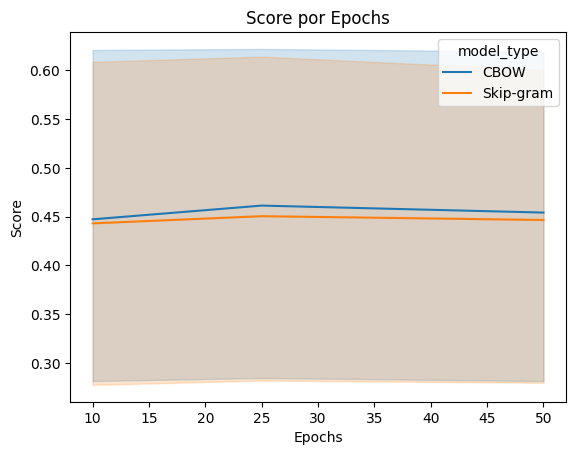

In [10]:
#score por epochs
sns.lineplot(x='epochs', y='score', hue='model_type', data=df_results)
plt.title('Score por Epochs')
plt.ylabel('Score')
plt.xlabel('Epochs')
plt.show()

#### O aumento da quantidade de épocas não demonstrou efeitos significativos, com o problema proposto. Isso indica que o modelo convege mais rápido que os valores propostos nas experimentações. Ou seja, a convergência se dá antes de 10 épocas.

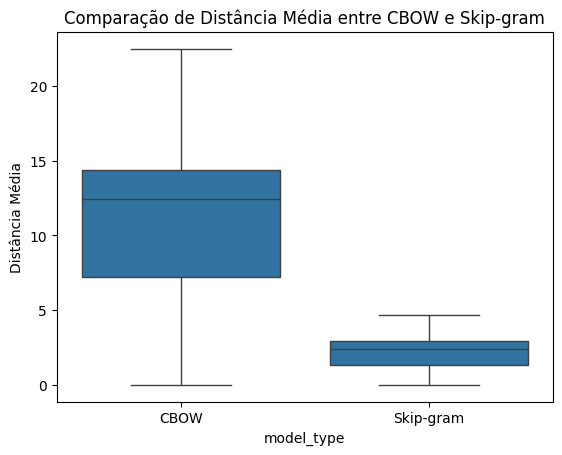

In [11]:
#Show average distance per model
sns.boxplot(x='model_type', y='avg_distance', data=df_results)
plt.title('Comparação de Distância Média entre CBOW e Skip-gram')
plt.ylabel('Distância Média')
plt.show()


##### Aqui podemos ver a relação entre distância do output do modelo para o Y esperado em ambos os modelos. É evidente que o modelo skipgram foi mais acurado que o CBOW, portanto mesmo que algumas outputs fossem errados eles ainda eram em geral mais acurados que os outputs dos modelos CBOW.